# CFAR Part 2

Now we will fully implement CA-CFAR across the Range Azimuth matrix and add in Doppler Values for each detection

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from utils.radar_params import *
from radar.range_processing import *
from radar.doppler_processing import *
from radar.azimuth_processing import *
from radar.cfar import *

%matplotlib inline

### Get Data

In [103]:
DATA_PATH = "../indoor_sample_50.h5"
CONFIG_PATH = "/home/iberrios/Documents/datasets/radical/data/radarcfg/indoor_human_rcs.cfg"

In [104]:
import h5py

data_dict = {}
with h5py.File(DATA_PATH, 'r') as h5_obj:
    for key in h5_obj.keys():
        data_dict.update({key : np.asarray(h5_obj[key])})

In [105]:
data_idx = 29
adc_data = data_dict['radar'][data_idx, ...]

### Get Range and Doppler bin values

In [106]:
with open(CONFIG_PATH, 'r') as f:
    for line in f.readlines():
        if 'profileCfg' in line:
            line = line.split(' ')

            start_freq = float(line[2]) # GHz
            idle_time = float(line[3]) # usec
            ramp_end_time = float(line[5]) # usec
            chirp_slope = float(line[8]) # MHz/usec
            num_adc_samples = float(line[10]) # unitless
            adc_sample_rate = float(line[11]) # Msps

        elif 'channelCfg' in line:
            line = line.split(' ')

            # number of receive antennas
            rx_bin = bin(int(line[1])).zfill(4)
            num_rx = len([i for i in rx_bin if i == '1'])

            # number of transmit antennas
            tx_bin = bin(int(line[2])).zfill(4)
            num_tx = len([i for i in tx_bin if i == '1'])


# print(f"Number of Rx Antennas: {num_rx}")
# print(f"Number of Tx Antennas: {num_tx}")
# print(f"Start Frequency: {start_freq} GHz")
# print(f"Idle Time: {idle_time} usec")
# print(f"Ramp End Time: {ramp_end_time} usec") # this should really be called ramp to end? or maybe just chirptime?
# print(f"Chirp Slope: {chirp_slope} MHz/usec")
# print(f"Number of ADC Samples: {num_adc_samples}")
# print(f"ADC sample rate: {adc_sample_rate} Msps")

In [107]:
range_resolution, bandwidth = compute_range_resolution(adc_sample_rate, num_adc_samples, chirp_slope)
max_range = range_resolution * num_adc_samples

num_chirps = adc_data.shape[0]
chirp_interval = (ramp_end_time + idle_time) * 1e-6 # usec

doppler_resolution = compute_doppler_resolution(num_chirps, bandwidth, chirp_interval, num_tx)
max_doppler = doppler_resolution * num_chirps / 2

### Process Data

In [108]:
# perform Fast Time Range FFT
range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0)

# perform Slow Time Doppler FFT
range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2)

# perform azimuth processing
steering_vector = compute_steering_vector(num_ant=8, angle_res=1, angle_rng=90)
range_azimuth = capon_spectrum(range_doppler, steering_vector)

## Apply CA-CFAR to Range Azimuth matrix

Don't take log before applying CFAR, we are computing the threshold assuming that the data follows an Exponential Distribution due to the square law detector that we are simulating by taking the square of the magnitude. If we take the log, then the data will follow more of a Normal Distribution and we will need to change our CFAR threshold computation to match this.

In [109]:
ranges = np.arange(0, max_range + range_resolution, range_resolution)

range_ticks = np.arange(0, len(ranges), len(ranges)//10)
range_tick_labels = ranges[::len(ranges)//10].round(2)

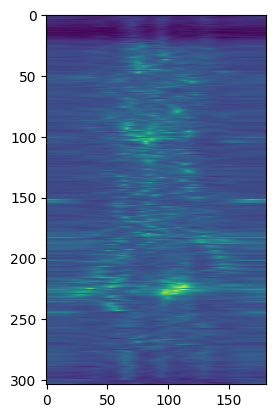

In [110]:
range_azimuth_psd = np.abs(range_azimuth)**2

plt.imshow(10*np.log10(range_azimuth_psd));

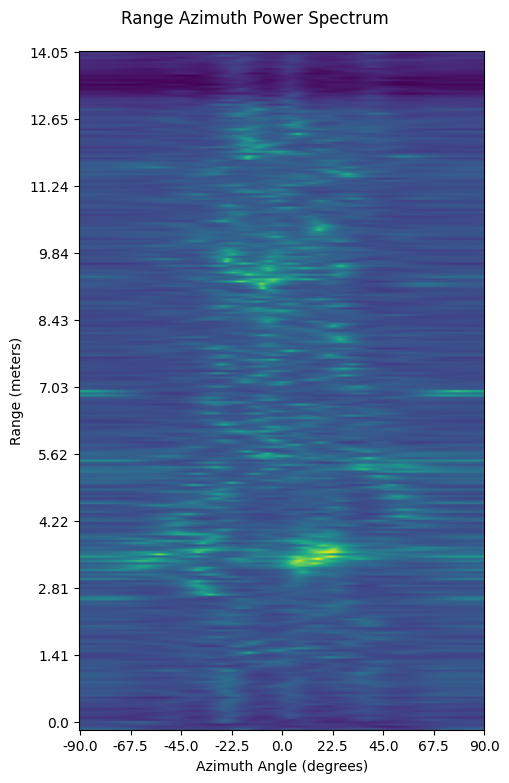

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
ax.imshow(10*np.log10(range_azimuth_psd));
fig.suptitle("Range Azimuth Power Spectrum");
ax.set_xlabel("Azimuth Angle (degrees)");
ax.set_ylabel("Range (meters)");

# apply Range and Doppler labels
ax.set_yticks(range_ticks, range_tick_labels[::-1]);

ax.set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1));

plt.tight_layout();

### Static Threshold experiment

Try detecting targets with a static threshold

In [112]:
rng_az_detections = range_azimuth_psd > range_azimuth_psd.mean()

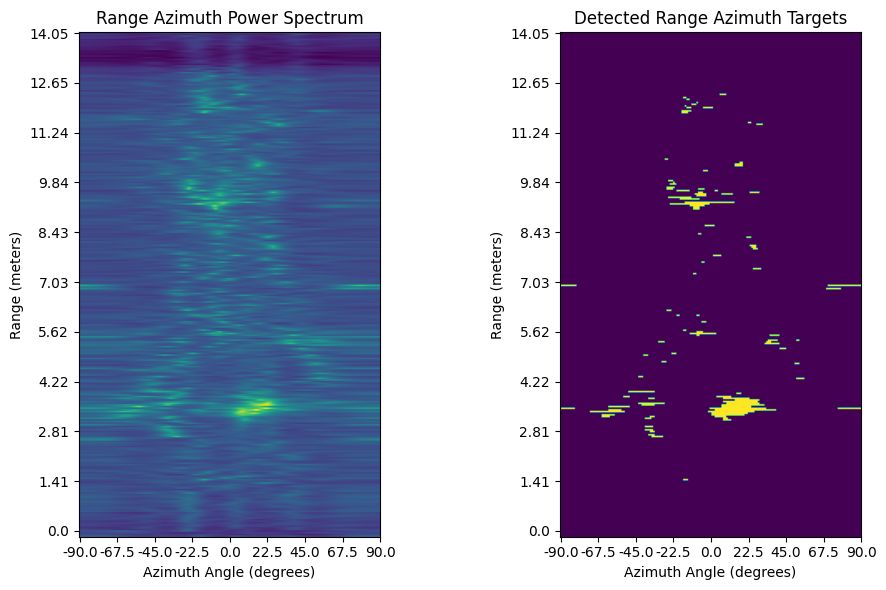

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].imshow(10*np.log10(range_azimuth_psd));
ax[0].set_xlabel("Azimuth Angle (degrees)");
ax[0].set_ylabel("Range (meters)");
ax[0].set_title("Range Azimuth Power Spectrum");

# apply Range and Doppler labels
ax[0].set_yticks(range_ticks, range_tick_labels[::-1]);
ax[0].set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1));

ax[1].imshow(rng_az_detections);
ax[1].set_xlabel("Azimuth Angle (degrees)");
ax[1].set_ylabel("Range (meters)");
ax[1].set_title("Detected Range Azimuth Targets");

# apply Range and Doppler labels
ax[1].set_yticks(range_ticks, range_tick_labels[::-1]);
ax[1].set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1));

plt.tight_layout();

In [114]:
# cfar in range direction
noise_level_rng, threshold_rng = np.apply_along_axis(ca_cfar, 
                                                 axis=0, 
                                                 arr=range_azimuth_psd,
                                                 prob_fa=0.05, 
                                                 num_train=10, 
                                                 num_gaurd=3)

# cfar in azimuth direction
noise_level_az, threshold_az = np.apply_along_axis(ca_cfar, 
                                                 axis=0, 
                                                 arr=range_azimuth_psd.T,
                                                 prob_fa=0.05, 
                                                 num_train=10, 
                                                 num_gaurd=3)

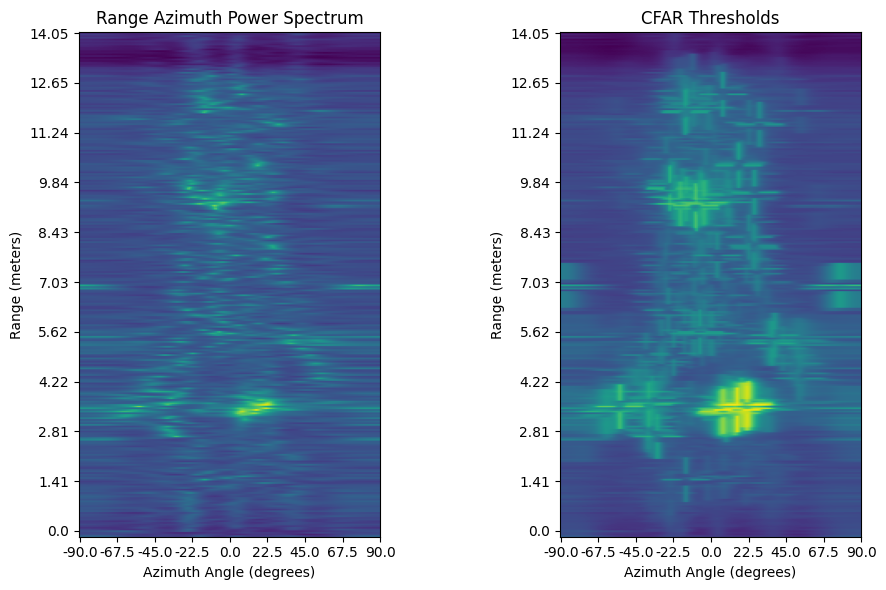

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].imshow(10*np.log10(range_azimuth_psd));
ax[0].set_xlabel("Azimuth Angle (degrees)");
ax[0].set_ylabel("Range (meters)");
ax[0].set_title("Range Azimuth Power Spectrum");

# apply Range and Doppler labels
ax[0].set_yticks(range_ticks, range_tick_labels[::-1]);
ax[0].set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1));

ax[1].imshow(np.log(threshold_rng + threshold_az.T));
ax[1].set_xlabel("Azimuth Angle (degrees)");
ax[1].set_ylabel("Range (meters)");
ax[1].set_title("CFAR Thresholds");

# apply Range and Doppler labels
ax[1].set_yticks(range_ticks, range_tick_labels[::-1]);
ax[1].set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1));

plt.tight_layout();

### Get Peaks

In [116]:
range_peaks = range_azimuth_psd > threshold_rng
azimuth_peaks = range_azimuth_psd > threshold_az.T

peaks = range_peaks & azimuth_peaks

# plt.imshow(peaks);

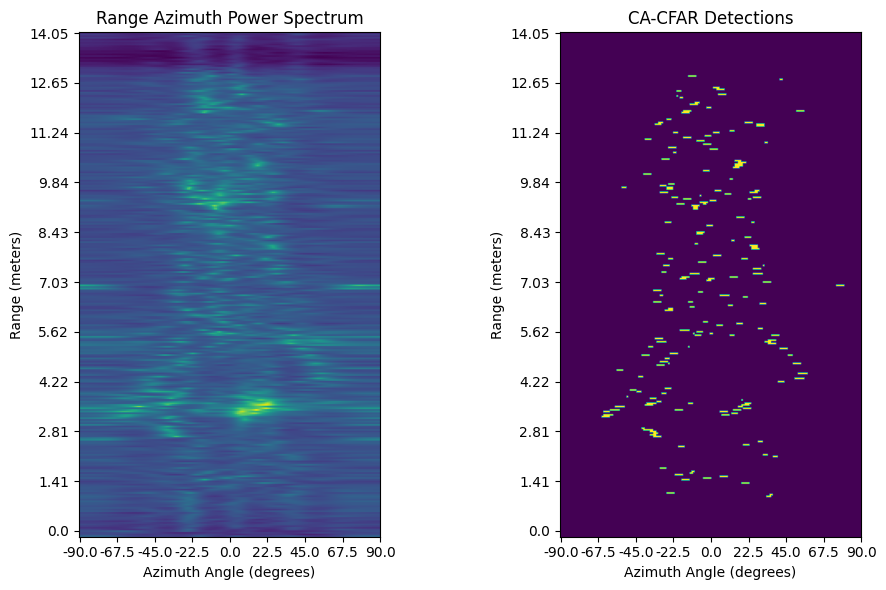

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].imshow(10*np.log10(range_azimuth_psd));
ax[0].set_xlabel("Azimuth Angle (degrees)");
ax[0].set_ylabel("Range (meters)");
ax[0].set_title("Range Azimuth Power Spectrum");

# apply Range and Doppler labels
ax[0].set_yticks(range_ticks, range_tick_labels[::-1]);
ax[0].set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1));

ax[1].imshow(peaks);
ax[1].set_xlabel("Azimuth Angle (degrees)");
ax[1].set_ylabel("Range (meters)");
ax[1].set_title("CA-CFAR Detections");

# apply Range and Doppler labels
ax[1].set_yticks(range_ticks, range_tick_labels[::-1]);
ax[1].set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1));

plt.tight_layout();

Perform Non-Max Supression to reduce peaks

In [118]:
# def get_nhood(arr, x, y, nsize=2):
#     return arr[y-nsize:y+nsize+1, x-nsize:x+nsize+1]

def get_nhood(arr, x, y, axis=None, nsize=2):
    
    if not axis:
        hood = arr[y-nsize:y+nsize+1, x-nsize:x+nsize+1]
    elif axis == 0:
        hood = arr[y-nsize:y+nsize+1, x]
    elif axis == 1:
        hood = arr[y, x-nsize:x+nsize+1]

    return hood


def cfar_nms(cfar_peaks, signal_arr, nsize=2):
    """ Performs non-maximal supprression on detected CFAR peaks """
    nms_peaks = np.zeros(cfar_peaks.shape)
    for y, x in zip(*np.where(cfar_peaks == 1)):
        if np.all(signal_arr[y, x] >= get_nhood(signal_arr, x, y, None, nsize)):
            nms_peaks[y, x] = 1

    return nms_peaks


def cfar_nms_single_ax(cfar_peaks, signal_arr, axis=None, nsize=2):
    """ Performs non-maximal supprression on detected CFAR peaks """
    nms_peaks = np.zeros(cfar_peaks.shape)
    for y, x in zip(*np.where(cfar_peaks == 1)):
        if np.all(signal_arr[y, x] >= get_nhood(signal_arr, x, y, axis, nsize)):
            nms_peaks[y, x] = 1

    return nms_peaks

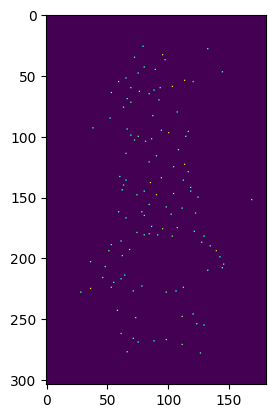

In [119]:
nms_peaks = cfar_nms(peaks, range_azimuth_psd, nsize=2)

plt.imshow(nms_peaks);

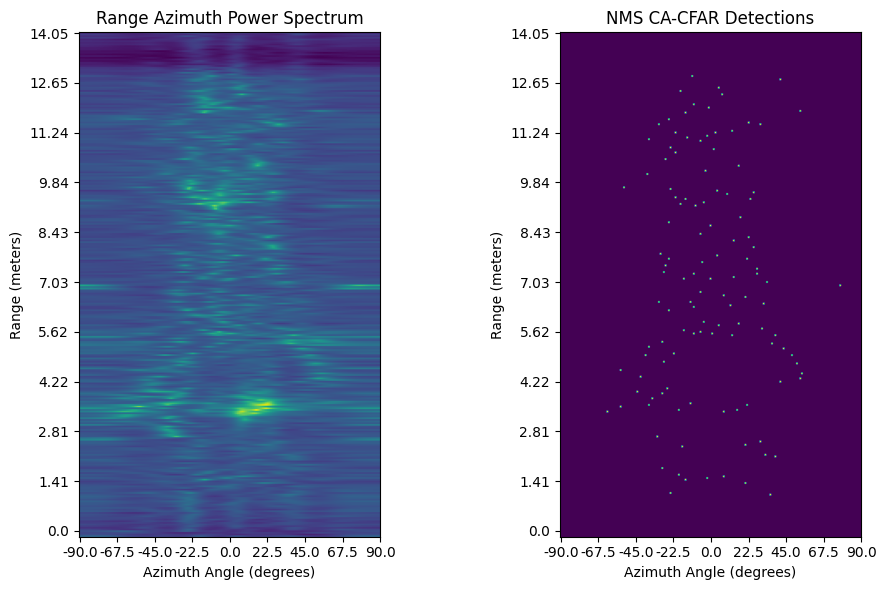

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].imshow(10*np.log10(range_azimuth_psd));
ax[0].set_xlabel("Azimuth Angle (degrees)");
ax[0].set_ylabel("Range (meters)");
ax[0].set_title("Range Azimuth Power Spectrum");

# apply Range and Doppler labels
ax[0].set_yticks(range_ticks, range_tick_labels[::-1]);
ax[0].set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1));

ax[1].imshow(nms_peaks);
ax[1].set_xlabel("Azimuth Angle (degrees)");
ax[1].set_ylabel("Range (meters)");
ax[1].set_title("NMS CA-CFAR Detections");

# apply Range and Doppler labels
ax[1].set_yticks(range_ticks, range_tick_labels[::-1]);
ax[1].set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1));

plt.tight_layout();

### Perform CFAR on Range Doppler PSD

For simplicity, we will consider each NMS Range and Azimuth location an individual target however, each range bin has corresponding Azimuth and Doppler components that could reveal additional target breakouts. 

In [121]:
# get properly scaled range doppler power spectrum
range_doppler_psd = np.abs(range_doppler.sum(axis=1)/8)**2 
range_doppler_psd = 10*np.log10(range_doppler_psd)

In [122]:
# We will perform CFAR on this spectrum
range_doppler_mag = np.abs(range_doppler.sum(axis=1))**2

In [123]:
# cfar in range direction --> Just to show what's possible
noise_level_rng, threshold_rng = np.apply_along_axis(ca_cfar, 
                                                 axis=0, 
                                                 arr=range_doppler_mag,
                                                 prob_fa=0.0001, 
                                                 num_train=10, 
                                                 num_gaurd=2)

# cfar in Doppler direction --> This is the one we will use
noise_level_dop, threshold_dop = np.apply_along_axis(ca_cfar, 
                                                 axis=0, 
                                                 arr=range_doppler_mag.T,
                                                 prob_fa=0.0001, 
                                                 num_train=10, 
                                                 num_gaurd=2)

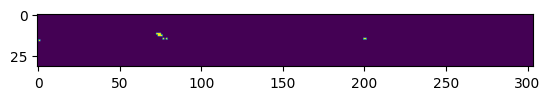

In [124]:
range_peaks = range_doppler_mag > threshold_rng
doppler_peaks = range_doppler_mag > threshold_dop.T

range_doppler_peaks = range_peaks & doppler_peaks

plt.imshow(range_doppler_peaks.T);

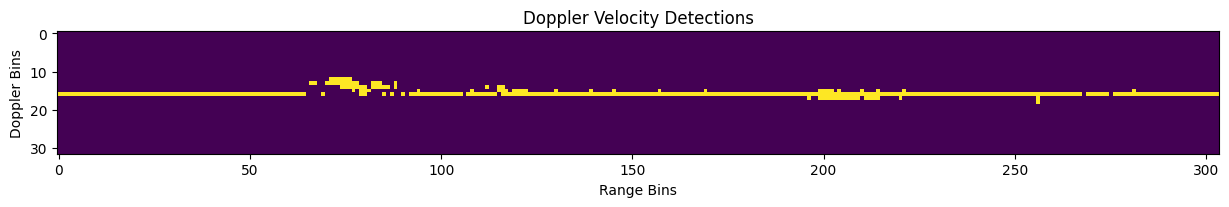

In [134]:
plt.figure(figsize=(15,5))
plt.imshow(doppler_peaks.T);
plt.xlabel("Range Bins")
plt.ylabel("Doppler Bins")
plt.title("Doppler Velocity Detections");

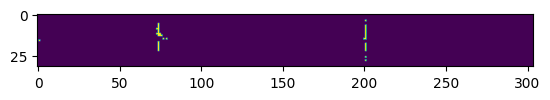

In [126]:
plt.imshow(range_peaks.T);

In [127]:
nms_doppler_peaks = cfar_nms_single_ax(doppler_peaks, range_doppler_mag, axis=1, nsize=1)

In [128]:
doppler_peaks.shape, range_doppler_mag.shape

((304, 32), (304, 32))

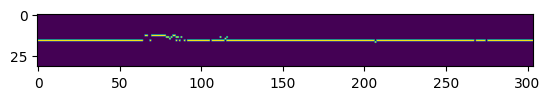

In [129]:
plt.imshow(nms_doppler_peaks.T);

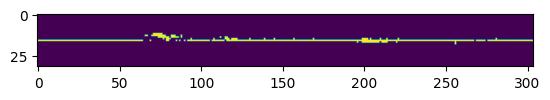

In [130]:
plt.imshow(doppler_peaks.T);

Display Doppler Detections

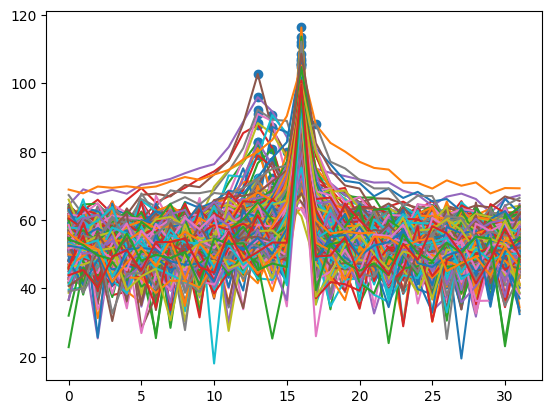

In [131]:
plt.plot(range_doppler_psd.T);
# plt.scatter(np.where(doppler_peaks)[1], 
#             range_doppler_psd[np.where(doppler_peaks)]);
plt.scatter(np.where(nms_doppler_peaks)[1], 
            range_doppler_psd[np.where(nms_doppler_peaks)]);

Display Range Detections

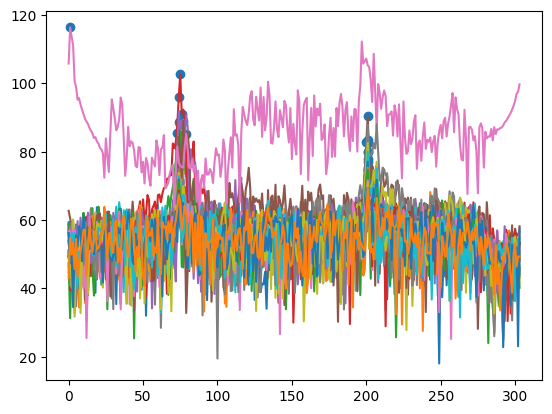

In [62]:
plt.plot(range_doppler_psd);
plt.scatter(np.where(range_peaks)[0], 
            range_doppler_psd[np.where(range_peaks)]);

In [63]:
range_locs, azimuth_locs = np.where(nms_peaks)
range_locs, azimuth_locs

(array([ 26,  28,  33,  35,  37,  43,  45,  47,  48,  52,  54,  55,  55,
         59,  60,  60,  62,  63,  64,  65,  69,  70,  72,  76,  80,  83,
         85,  93,  94,  95,  96,  97,  99, 100, 100, 102, 103, 104, 111,
        114, 116, 121, 123, 125, 129, 133, 134, 136, 136, 138, 140, 142,
        144, 145, 145, 147, 148, 148, 150, 152, 156, 158, 159, 162, 162,
        163, 164, 165, 167, 174, 175, 176, 178, 179, 180, 181, 181, 182,
        182, 186, 187, 189, 190, 193, 194, 194, 198, 199, 203, 205, 207,
        208, 210, 214, 216, 217, 220, 223, 224, 224, 225, 227, 227, 228,
        228, 243, 246, 248, 249, 254, 255, 262, 266, 267, 268, 269, 271,
        277, 278]),
 array([ 79, 132,  95,  72,  97,  80,  89, 144,  75,  65, 113,  59, 120,
        103,  69,  93,  88,  76,  53,  84,  66,  92,  69,  63, 107,  87,
         52,  38,  66,  94, 116, 100,  69,  75, 114,  86,  72,  81, 108,
         65,  90,  84, 113, 104, 116,  60,  94,  65, 112,  85,  63, 118,
         62,  80, 118, 104,  74

In [64]:
ranges = (num_adc_samples - range_locs) * range_resolution

angle_vector = np.arange(-90, 91, 1)
angles = angle_vector[azimuth_locs]

#### Generate CFAR Point Cloud

Each entry to this point cloud contains (range, Azimuth, 32 Doppler Velocity values), in the 3D case we would have an additional entry for Elevation angle.

In [65]:
cfar_cloud = np.hstack((ranges[:, None], 
                        angles[:, None], 
                        range_doppler_psd[int(num_adc_samples) - range_locs, :])
                        )
cfar_cloud.shape

(119, 34)

In [66]:
doppler_locs = doppler_peaks[int(num_adc_samples) - range_locs, :]
# doppler_locs = nms_doppler_peaks[int(num_adc_samples) - range_locs, :]

doppler_locs.shape

(119, 32)

In [67]:
cfar_cloud[0, :]

array([ 13.02086413, -11.        ,  51.88966979,  53.16880397,
        55.30589582,  56.5565618 ,  45.71369702,  49.8469732 ,
        50.11498641,  44.01322909,  58.72225763,  47.65023871,
        48.66839227,  53.05686078,  52.78790308,  57.14245055,
        50.8528216 ,  62.11439835,  86.93030394,  56.0135232 ,
        52.2927071 ,  56.1629636 ,  58.73154627,  53.47964346,
        47.48119015,  50.01730672,  56.97061979,  57.32981611,
        60.21894846,  57.02926433,  50.77822637,  50.24717212,
        59.86911792,  51.71309468])

In [68]:
np.where(doppler_locs)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   8,   8,   9,  10,
         11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
         24,  25,  25,  26,  27,  27,  28,  28,  29,  29,  30,  30,  31,
         31,  32,  32,  33,  33,  33,  34,  34,  34,  35,  35,  35,  36,
         36,  36,  37,  37,  37,  38,  39,  40,  41,  42,  43,  44,  45,
         46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  55,  56,  57,
         58,  59,  60,  61,  62,  62,  63,  64,  65,  66,  67,  67,  68,
         69,  69,  70,  71,  72,  73,  74,  75,  76,  77,  77,  78,  78,
         79,  80,  80,  81,  81,  82,  83,  84,  85,  87,  88,  89,  90,
         91,  92,  92,  93,  94,  94,  95,  96,  96,  97,  98,  98,  98,
         99,  99,  99, 100, 100, 100, 101, 101, 101, 102, 102, 102, 103,
        103, 103, 104, 104, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118]),
 array([16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 18, 16, 16, 16, 16, 16, 16,
        

In [69]:
dopplers = range_doppler_psd[int(num_adc_samples) - range_locs, :]

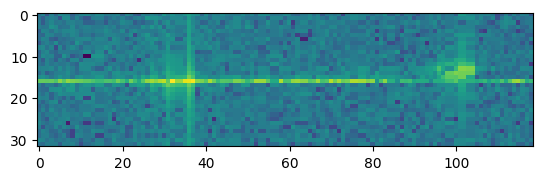

In [90]:
plt.imshow(dopplers.T)

In [84]:
range_doppler_psd.shape

(304, 32)

In [98]:
range_locs, doppler_locs.shape, azimuth_locs.shape

(array([ 26,  28,  33,  35,  37,  43,  45,  47,  48,  52,  54,  55,  55,
         59,  60,  60,  62,  63,  64,  65,  69,  70,  72,  76,  80,  83,
         85,  93,  94,  95,  96,  97,  99, 100, 100, 102, 103, 104, 111,
        114, 116, 121, 123, 125, 129, 133, 134, 136, 136, 138, 140, 142,
        144, 145, 145, 147, 148, 148, 150, 152, 156, 158, 159, 162, 162,
        163, 164, 165, 167, 174, 175, 176, 178, 179, 180, 181, 181, 182,
        182, 186, 187, 189, 190, 193, 194, 194, 198, 199, 203, 205, 207,
        208, 210, 214, 216, 217, 220, 223, 224, 224, 225, 227, 227, 228,
        228, 243, 246, 248, 249, 254, 255, 262, 266, 267, 268, 269, 271,
        277, 278]),
 (119, 32),
 (119,))

In [137]:
detected_dopplers

array([16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 18, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 17, 15, 16,
       16, 17, 16, 17, 16, 17, 16, 17, 15, 16, 17, 15, 16, 17, 15, 16, 17,
       15, 16, 17, 15, 16, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16,
       16, 16, 16, 15, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16,
       15, 16, 16, 15, 16, 14, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15,
       16, 16, 13, 14, 16, 13, 14, 15, 14, 15, 16, 14, 15, 16, 14, 15, 16,
       13, 14, 15, 13, 14, 15, 12, 13, 14, 12, 13, 14, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16])

In [145]:
tmp = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)
tmp = np.tile(np.c_[tmp], len(detected_dopplers))
tmp.shape

(33, 162)

In [150]:
tmp[detected_dopplers].shape

(162, 162)

In [70]:
detected_ranges = ranges[np.where(doppler_locs)[0]]
detected_angles = angles[np.where(doppler_locs)[0]]
detected_dopplers = np.where(doppler_locs)[1] # Doppler Bins
detected_doppler_mag = dopplers[np.where(doppler_locs)[0], np.where(doppler_locs)[1]]

In [71]:
detected_ranges.shape, detected_angles.shape, detected_dopplers.shape

((162,), (162,), (162,))

In [72]:
detections = np.stack((detected_ranges, detected_angles, detected_dopplers, detected_doppler_mag)).T
detections.shape

(162, 4)

In [73]:
detections

array([[ 13.02086413, -11.        ,  16.        ,  86.93030394],
       [ 12.92718885,  42.        ,  16.        ,  87.07744311],
       [ 12.69300065,   5.        ,  16.        ,  86.42315239],
       [ 12.59932537, -18.        ,  16.        ,  87.18883417],
       [ 12.50565008,   7.        ,  16.        ,  83.7445941 ],
       [ 12.22462424, -10.        ,  16.        ,  92.53385431],
       [ 12.13094896,  -1.        ,  16.        ,  85.69968936],
       [ 12.03727368,  54.        ,  16.        ,  93.6504081 ],
       [ 11.99043604, -15.        ,  16.        ,  90.39161391],
       [ 11.99043604, -15.        ,  17.        ,  68.43377828],
       [ 11.99043604, -15.        ,  18.        ,  67.23509443],
       [ 11.80308547, -25.        ,  16.        ,  88.97469287],
       [ 11.70941019,  23.        ,  16.        ,  87.85361182],
       [ 11.66257255, -31.        ,  16.        ,  85.94785661],
       [ 11.66257255,  30.        ,  16.        ,  85.94785661],
       [ 11.47522199,  13

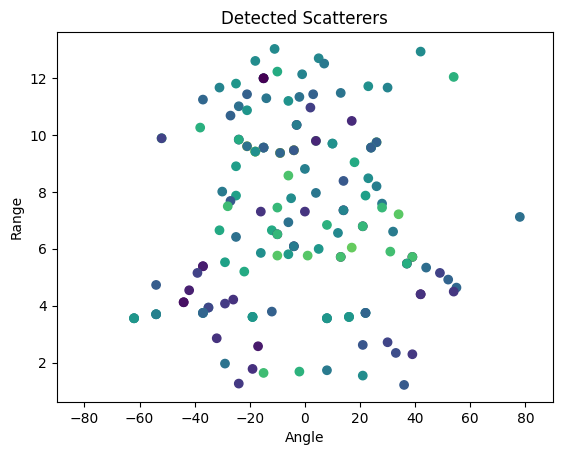

In [74]:
plt.scatter(detections[:, 1], detections[:, 0], c=detections[:, 3])
plt.xlim(-90, 90)
plt.title("Detected Scatterers")
plt.xlabel("Angle")
plt.ylabel("Range");

In [75]:
moving = detections[:, 2] != 16

moving_detections = detections[moving, :]

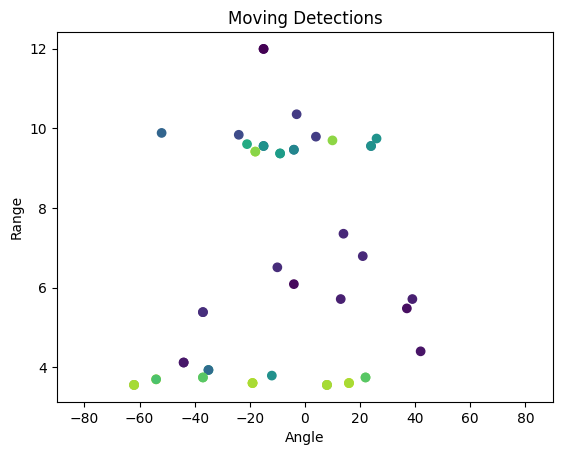

In [76]:
plt.scatter(moving_detections[:, 1], moving_detections[:, 0], c=moving_detections[:, 3])
plt.xlim(-90, 90)
plt.title("Moving Detections")
plt.xlabel("Angle")
plt.ylabel("Range");

In [77]:
import cv2


def plot_points(image, points, radius=3, color=(0,255,0)):
    for x,y in points:
        cv2.circle(image, (int(x), int(y)), radius, color, thickness=-1)

    return image

In [78]:
range_az_img = cv2.normalize(np.log(range_azimuth_psd), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
range_az_img = range_az_img[:, :, None].repeat(3, axis=2)

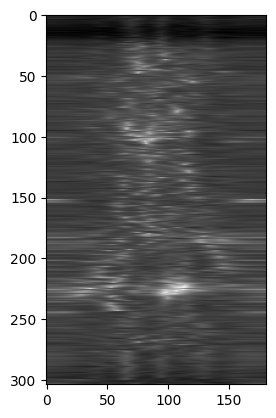

In [79]:
plt.imshow(range_az_img);

In [80]:
for rng, az, dop in detections[:, :3]:
    rng = int(num_adc_samples - rng/range_resolution)
    az = int(az + 90)

    if dop == 16:
        cv2.circle(range_az_img, (az, rng), radius=1, color=(0,255,0), thickness=-1)
    else:
        cv2.circle(range_az_img, (az, rng), radius=1, color=(255,0,255), thickness=-1)

In [81]:
ranges = np.arange(0, max_range + range_resolution, range_resolution)

range_ticks = np.arange(0, len(ranges), len(ranges)//10)
range_tick_labels = ranges[::len(ranges)//10].round(2)

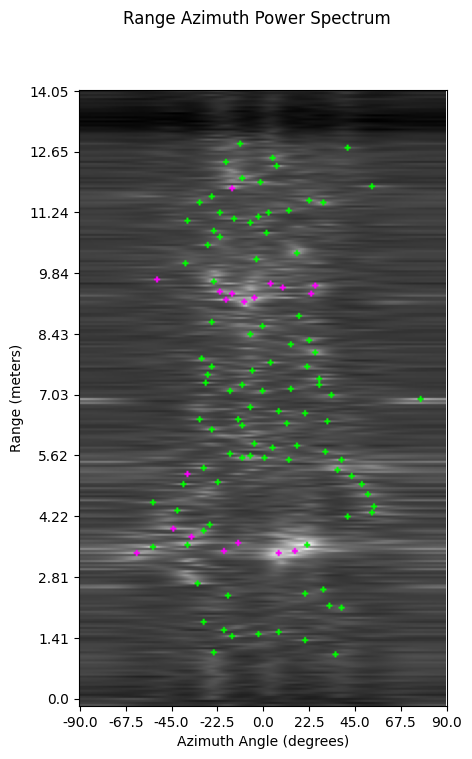

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
ax.imshow(range_az_img);
fig.suptitle("Range Azimuth Power Spectrum");
ax.set_xlabel("Azimuth Angle (degrees)");
ax.set_ylabel("Range (meters)");

# apply Range and Doppler labels
ax.set_yticks(range_ticks, range_tick_labels[::-1]);

ax.set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1));

## Now make video

In [257]:
def apply_cfar(signal_array, cfar_func, *args):
    """ Perform cfar on a given signal matrix
        Inputs:
        Outputs:  
    """
    (prob_fa_1, 
     num_train_1, 
     num_gaurd_1, 
     prob_fa_2, 
     num_train_2, 
     num_gaurd_2) = args
    
    # cfar in direction 1
    noise_level_1, threshold_1 = np.apply_along_axis(cfar_func, 
                                                    axis=0, 
                                                    arr=signal_array,
                                                    prob_fa=prob_fa_1, 
                                                    num_train=num_train_1, 
                                                    num_gaurd=num_gaurd_1)

    # cfar in direction 2
    noise_level_2, threshold_2 = np.apply_along_axis(cfar_func, 
                                                    axis=0, 
                                                    arr=signal_array.T,
                                                    prob_fa=prob_fa_2, 
                                                    num_train=num_train_2, 
                                                    num_gaurd=num_gaurd_2)
    
    
    return (noise_level_1, threshold_1, noise_level_2, threshold_2)

In [258]:
steering_vector = compute_steering_vector(num_ant=8, angle_res=1, angle_rng=90)
angle_vector = np.arange(-90, 91, 1)

In [277]:
frames = []

for i in range(len(data_dict['radar'])):

    ################################################################################
    ## get raw ADC data
    adc_data = data_dict['radar'][i, ...]

    # perform Fast Time Range FFT
    range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0)

    # perform Slow Time Doppler FFT
    range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2)

    # perform azimuth processing
    range_azimuth = capon_spectrum(range_doppler, steering_vector)

    ################################################################################
    ## perform CFAR detection on non log range azimuth PSD
    range_azimuth_psd = np.abs(range_azimuth)**2

    # cfar in range direction
    noise_level_rng, threshold_rng = np.apply_along_axis(ca_cfar, 
                                                    axis=0, 
                                                    arr=range_azimuth_psd,
                                                    prob_fa=0.05, 
                                                    num_train=10, 
                                                    num_gaurd=3)

    # cfar in azimuth direction
    noise_level_az, threshold_az = np.apply_along_axis(ca_cfar, 
                                                    axis=0, 
                                                    arr=range_azimuth_psd.T,
                                                    prob_fa=0.05, 
                                                    num_train=10, 
                                                    num_gaurd=3)
    
    # get NMS peaks
    range_peaks = range_azimuth_psd > threshold_rng
    azimuth_peaks = range_azimuth_psd > threshold_az.T
    peaks = range_peaks & azimuth_peaks
    
    nms_peaks = cfar_nms(peaks, range_azimuth_psd, nsize=2)

    # get detected range and azimuth locs
    range_locs, azimuth_locs = np.where(nms_peaks)
    
    ################################################################################
    ## get Doppler CFAR
    range_doppler_mag = np.abs(range_doppler.sum(axis=1))**2

    # get properly scaled range doppler power spectrum
    range_doppler_psd = np.abs(range_doppler.sum(axis=1)/8)**2 
    range_doppler_psd = 10*np.log10(range_doppler_psd)

    noise_level_dop, threshold_dop = np.apply_along_axis(ca_cfar, 
                                                 axis=0, 
                                                 arr=range_doppler_mag.T,
                                                 prob_fa=0.0001, 
                                                 num_train=10, 
                                                 num_gaurd=2)
    
    doppler_peaks = range_doppler_mag > threshold_dop.T
    doppler_locs = doppler_peaks[int(num_adc_samples) - range_locs, :]

    ################################################################################
    # get ranges, angles, and Dopplers
    ranges = (num_adc_samples - range_locs) * range_resolution
    angles = angle_vector[azimuth_locs]
    dopplers = range_doppler_psd[int(num_adc_samples) - range_locs, :]

    # get detections
    detected_ranges = ranges[np.where(doppler_locs)[0]]
    detected_angles = angles[np.where(doppler_locs)[0]]
    detected_dopplers = np.where(doppler_locs)[1] # Doppler Bins
    detected_doppler_mag = dopplers[np.where(doppler_locs)[0], np.where(doppler_locs)[1]]

    detections = np.stack((detected_ranges, 
                           detected_angles, 
                           detected_dopplers, 
                           detected_doppler_mag)).T


    ################################################################################
    ## draw detections on Range Az PSD
    
    # convert to normalized uint8 to save with opencv video writer
    range_az_img = cv2.normalize(np.log(range_azimuth_psd), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    range_az_img = range_az_img[:, :, None].repeat(3, axis=2)

    for rng, az, dop in detections[:, :3]:
        rng = int(num_adc_samples - rng/range_resolution)
        az = int(az + 90)

        if dop == 16:
            cv2.circle(range_az_img, (az, rng), radius=1, color=(0,255,0), thickness=-1)
        else:
            cv2.circle(range_az_img, (az, rng), radius=1, color=(255,0,255), thickness=-1)


    ################################################################################
    # obtain rgb image and resize
    rgb = data_dict['rgb'][i, ...]
    ih, iw = rgb.shape[:2]
    iw2, ih2 = int(iw/2.361), int(ih/2.361)

    rgb = cv2.resize(rgb, (iw2, ih2))
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    zero_pad = np.zeros((ih2, 2, 3), dtype=np.uint8)

    frame = np.hstack((rgb, zero_pad, range_az_img))

    # append frame to list
    frames.append(frame)

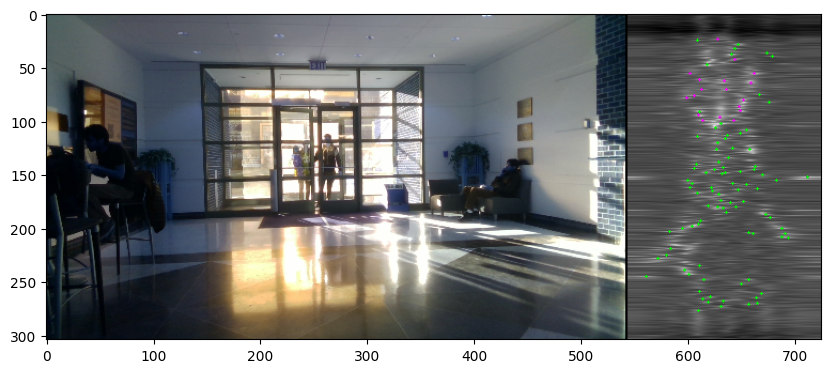

In [306]:
plt.figure(figsize=(10, 10))
plt.imshow(frames[19]);

In [300]:
h, w = frame.shape[:2]

out = cv2.VideoWriter("../videos/range_azimuth_cfar.avi",
                      cv2.VideoWriter_fourcc(*'DIVX'), # *'mp4v' *'MJPG' *'h264' *'x264' *'DIVX'
                      3,
                      (w, h))

for frame in frames:
    out.write(frame)

out.release()
del out